In [1]:
# Calculations here are not needed since the excitation efficiency is fully characterized for real indicators.
# However, here we show that simulating emission efficiencies as gaussians of width 20-80 nm is reasonable
# Fitting gaussians with 3 data points is underconstrained, and the initial conditions matter a lot.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.nn.parameter import Parameter
from sourcesep.utils.config import load_config

sns.set()
paths = load_config(dataset_key='all')

Paths are for dataset tagged: all


In [2]:
def gauss(x, mu, sig): return np.exp(-(x-mu)**2/(sig**2))

def optimize_gauss(mu=500., sig=10., xdat=None, ydat=None, n_steps=10000, plot=True):

    mu_param = Parameter(torch.tensor(mu), requires_grad=True)
    sig_param = Parameter(torch.tensor(sig), requires_grad=True)
    optimizer = torch.optim.Adam([mu_param, sig_param])

    for step in range(n_steps):
        y_pred = torch.exp(-(mu_param-torch.as_tensor(xdat))**2/(sig_param**2))
        loss = torch.sum((torch.as_tensor(ydat) - y_pred)**2)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    mu_fit = mu_param.detach().numpy()
    sig_fit = sig_param.detach().numpy()
    if plot:
        x = np.arange(300, 700)
        f, ax = plt.subplots(1, 1, figsize=(4, 3))
        ax.plot(xdat, ydat, 'xr', label='Data')
        ax.plot(x, gauss(x, mu_fit, sig_fit), '--', label='Fit')
        plt.legend()
        plt.show()
    print(f'Mu: {mu_fit:0.2f}, Sigma: {sig_fit:0.2f}')
    return dict(mu=mu_fit, sig=sig_fit)

In [3]:
# values provided by Smrithi
W = dict(EGFP=dict(xdat=[473.,514.,561.], ydat=[0.81, 0.15, 0.]),
    Venus=dict(xdat=[473.,514.,561.], ydat=[0.22, 1.00, 0.]),
    mApple=dict(xdat=[473.,514.,561.], ydat=[0.1, 0.39, 0.9]))

In [4]:
fits = dict()
fits['EGFP'] = optimize_gauss(mu = 480., sig=30., xdat=W['EGFP']['xdat'], ydat=W['EGFP']['ydat'], plot=False)
fits['Venus'] = optimize_gauss(mu = 500., sig=30., xdat=W['Venus']['xdat'], ydat=W['Venus']['ydat'], plot=False)
fits['mApple'] = optimize_gauss(mu = 600., sig=80., xdat=W['mApple']['xdat'], ydat=W['mApple']['ydat'], plot=False)

Mu: 483.25, Sigma: 22.40
Mu: 507.59, Sigma: 28.07
Mu: 592.48, Sigma: 81.78


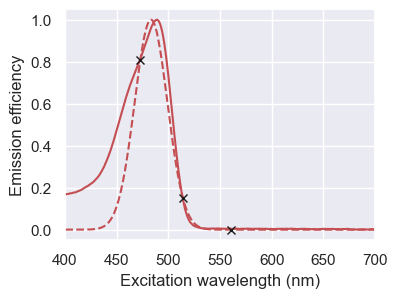

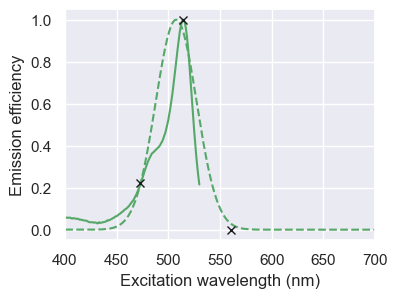

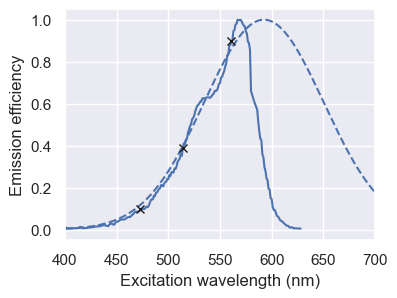

In [5]:
col = ['r', 'g', 'b']
x = np.arange(300, 800)
for i, indicator in enumerate(['EGFP', 'Venus', 'mApple']):
    f, ax = plt.subplots(1, 1, figsize=(4, 3))
    y = gauss(x,fits[indicator]['mu'],fits[indicator]['sig'])
    df = pd.read_csv(paths['spectra'] / f'{indicator}.csv')
    ax.plot(x, y, '--', label='fit', color=col[i])
    ax.plot(df['wavelength'], df[f'{indicator} ex'], label='efficiency', color=col[i])
    ax.plot(W[indicator]['xdat'], W[indicator]['ydat'], 'xk')
    ax.set(xlim=(400, 700),
           xlabel='Excitation wavelength (nm)',
           ylabel='Emission efficiency')
    plt.show()
